In [233]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set_style('darkgrid')

In [234]:
CONFIRMED_CASES_DATASET_PATH = 'data/covid_confirmed_usafacts.csv'
DEATHS_DATASET_PATH = 'data/covid_deaths_usafacts.csv'
POPULATION_DATASET_PATH = 'data/covid_county_population_usafacts.csv'
COUNTRIES_CONFIRMED_CASES_DATASET_PATH = 'data/owid-covid-data-cases.csv'
COUNTRIES_DEATHS_DATASET_PATH = 'data/owid-covid-data-deaths.csv'
START_YEAR = 2022
START_MONTH = 6
START_DAY = 1
END_YEAR = 2022
END_MONTH = 12
END_DAY = 31
LOWER_INTERVAL_BOUND = dt.datetime(START_YEAR, START_MONTH, START_DAY)  # Datetime object from which the analysis on the data starts
UPPER_INTERVAL_BOUND = dt.datetime(END_YEAR, END_MONTH, END_DAY)        # Datetime object from which the analysis on the data ends
COUNTRIES = ['Indonesia','Pakistan','Nigeria']
NORMALIZATION_FACTOR = 1000000      # Normalization factor used

In [235]:
def get_df_from_to(df, start_date=LOWER_INTERVAL_BOUND, end_date=UPPER_INTERVAL_BOUND):
    """ 
    A method to return a snipped time interval from a bigger dataframe
    Args:
        df (Pandas.DataFrame): Dataframe with columns as datetime
        start_date (Datetime, optional): Defaults to LOWER_INTERVAL_BOUND.
        end_date (Datetime, optional): Defaults to UPPER_INTERVAL_BOUND.

    Returns:
        DataFrame
    """
    f = lambda col: col if dt.datetime.strptime(col, '%Y-%m-%d') <= end_date and dt.datetime.strptime(col, '%Y-%m-%d') >= start_date else None
    covid_recent_cols = [col for col in df.columns[:4]]
    covid_recent_cols += ([f(col) for col in df.columns[5:]])
    covid_from_to = []
    for col in covid_recent_cols:
        if col is not None:
            covid_from_to.append(col)
    return df[covid_from_to]

def normalize(df, pop, nf=NORMALIZATION_FACTOR):
    """
    Returns a normalized version of the dataframe

    Args:
        df (Dataframe):
        pop (int): Population of the selected jurisdiction
        nf (int, optional): Normalization Factor. Defaults to NORMALIZATION_FACTOR.

    Returns:
        Dataframe:
    """
    return (df/pop) * nf

def get_us_population():
    pop_df = pd.read_csv(POPULATION_DATASET_PATH)
    return pop_df['population'].agg(np.sum, axis=0)

def get_us_new_cases_and_deaths():
    """
    Returns a dataframe of the cases and deaths in the US

    Returns:
        Dataframe:
    """
    us_covid_cases_df = get_df_from_to(pd.read_csv(CONFIRMED_CASES_DATASET_PATH))
    us_covid_deaths_df = get_df_from_to(pd.read_csv(DEATHS_DATASET_PATH))
    us_covid_cases_df = us_covid_cases_df[us_covid_cases_df['countyFIPS'] != 0]
    us_covid_deaths_df = us_covid_deaths_df[us_covid_deaths_df['countyFIPS'] != 0]
    us_covid_cases_df.drop(['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1, inplace=True)
    us_covid_deaths_df.drop(['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1, inplace=True)
    us_covid_cases_df = us_covid_cases_df.agg(np.sum, axis=0)
    us_covid_deaths_df = us_covid_deaths_df.agg(np.sum, axis=0)
    us_covid_time_series_df = pd.concat([us_covid_cases_df, us_covid_deaths_df], axis=1).diff(axis=0)
    us_covid_time_series_df.drop(us_covid_time_series_df.index[0], inplace=True)
    us_covid_time_series_df.columns = ['Cases', 'Deaths']
    us_covid_time_series_df.index = pd.to_datetime(us_covid_time_series_df.index)
    return us_covid_time_series_df

def get_weekly_statistics(df, statistic='mean'):
    """
    Returns a specific statistic from the input dataframe
    Args:
        df (Dataframe):
        statistic (str, optional): Defaults to 'mean'.

    Returns:
        Dataframe:
    """
    if statistic == 'mode':
        return df.groupby(df.index.isocalendar().week, axis=0).agg(lambda entry: entry.mode().to_numpy()[-1])
    elif statistic == 'median':
        return df.groupby(df.index.isocalendar().week, axis=0).median()
    elif statistic == 'mean':
        return df.groupby(df.index.isocalendar().week, axis=0).mean()
    else:
        return df.groupby(df.index.isocalendar().week, axis=0).sum()
    
def get_country_new_cases_and_deaths(country_name):
    countries_cases_df = pd.read_csv(COUNTRIES_CONFIRMED_CASES_DATASET_PATH)[['location', 'date', 'new_cases', 'new_deaths']]
    countries_cases_df = countries_cases_df[countries_cases_df['location'] == country_name]
    country_1_cases_df = countries_cases_df.set_index('date').drop('location', axis=1)
    country_1_cases_df.columns = ['Cases', 'Deaths']
    country_1_cases_df.index = pd.to_datetime(country_1_cases_df.index)
    country_1_cases_df.index.name = None
    country_1_cases_df = country_1_cases_df.dropna()
    country_1_cases_df = country_1_cases_df[country_1_cases_df.index.to_series().between(LOWER_INTERVAL_BOUND, UPPER_INTERVAL_BOUND)]
    return country_1_cases_df

def get_country_population(country_name):
    df = pd.read_csv(COUNTRIES_CONFIRMED_CASES_DATASET_PATH)[['location', 'population']]
    df = df[df['location'] == country_name]
    return df['population'].iloc[0]

In [236]:
us_df = get_us_new_cases_and_deaths()
us_mean = get_weekly_statistics(us_df, 'mean').round()
us_median = get_weekly_statistics(us_df, 'median').round()
us_mode = get_weekly_statistics(us_df, 'mode').round()
us_pop = get_us_population()
us_normalized_df = normalize(us_df, us_pop)
us_normalized_df_mean = get_weekly_statistics(us_normalized_df, 'mean').round()
us_normalized_df_median = get_weekly_statistics(us_normalized_df, 'median')
us_normalized_df_mode = get_weekly_statistics(us_normalized_df, 'mode')

In [237]:
us_cases_stat = pd.concat([us_mean['Cases'], us_median['Cases'], us_mode['Cases']], keys=['Mean', 'Median', 'Mode'], axis=1)
us_deaths_stat = pd.concat([us_mean['Deaths'], us_median['Deaths'], us_mode['Deaths']], keys=['Mean', 'Median', 'Mode'], axis=1)

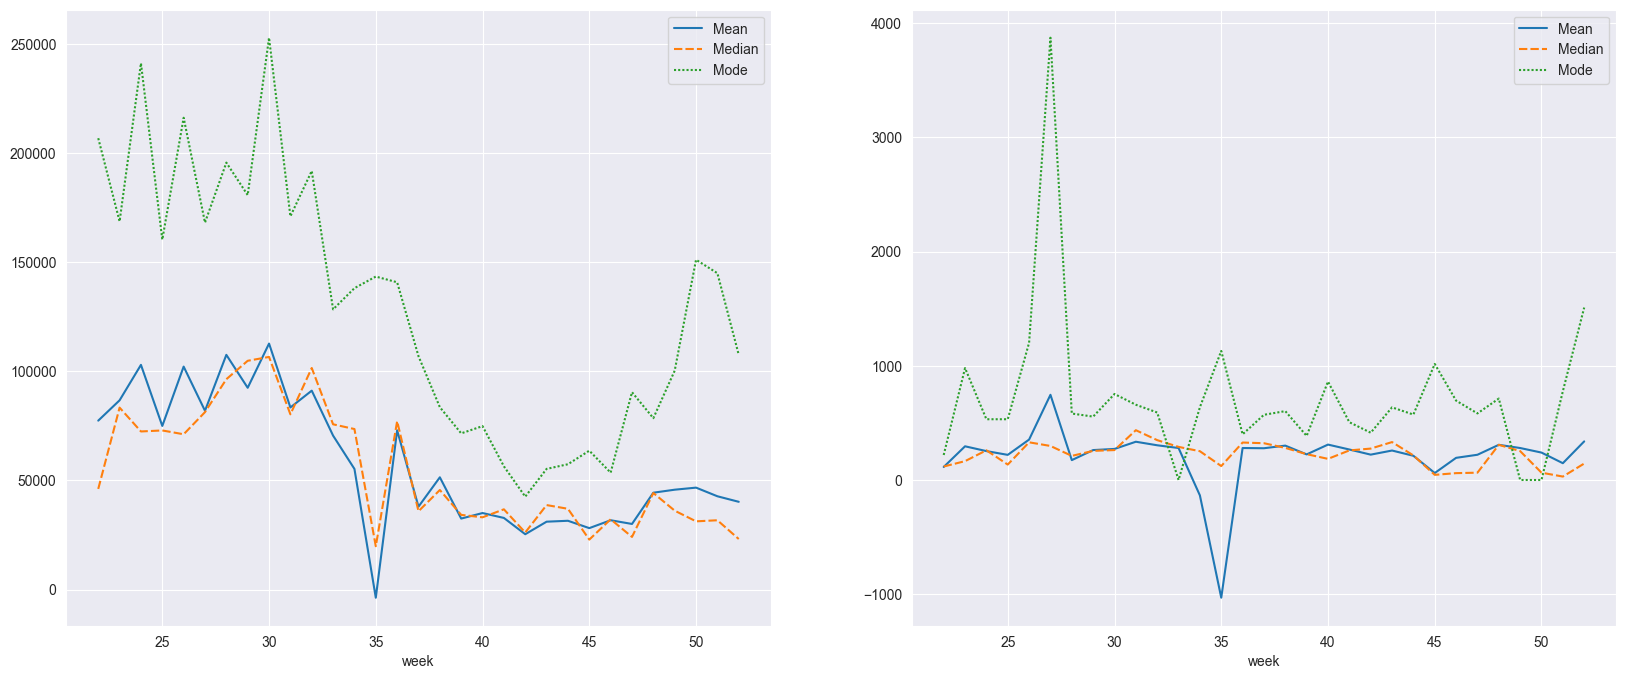

In [238]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot = sns.lineplot(data=us_cases_stat, ax=ax[0])
plot = sns.lineplot(data=us_deaths_stat, ax=ax[1])

In [239]:
print("\tMean\n{}".format(us_mean.mean().round()))
print("\tMedian\n{}".format(us_mean.median()))
print("\tMode\n{}".format(us_mean.mode()))

	Mean
Cases     57935.0
Deaths      212.0
dtype: float64
	Median
Cases     46699.0
Deaths      262.0
dtype: float64
	Mode
       Cases  Deaths
0    -3756.0   280.0
1    25348.0     NaN
2    28138.0     NaN
3    30053.0     NaN
4    31093.0     NaN
5    31511.0     NaN
6    31751.0     NaN
7    32519.0     NaN
8    32811.0     NaN
9    35056.0     NaN
10   37978.0     NaN
11   40203.0     NaN
12   42742.0     NaN
13   44378.0     NaN
14   45752.0     NaN
15   46699.0     NaN
16   51433.0     NaN
17   55270.0     NaN
18   70535.0     NaN
19   72985.0     NaN
20   74973.0     NaN
21   77405.0     NaN
22   81926.0     NaN
23   83448.0     NaN
24   86727.0     NaN
25   91147.0     NaN
26   92464.0     NaN
27  102170.0     NaN
28  102963.0     NaN
29  107556.0     NaN
30  112719.0     NaN


In [240]:
country_1_df = get_country_new_cases_and_deaths(COUNTRIES[0])
country_1_df_mean = get_weekly_statistics(country_1_df, 'mean').round()
country_1_df_median = get_weekly_statistics(country_1_df, 'median')
country_1_df_mode = get_weekly_statistics(country_1_df, 'mode')
country_1_df_pop = get_country_population(COUNTRIES[0])
country_1_normalized_df = normalize(country_1_df, country_1_df_pop)
country_1_normalized_df_mean = get_weekly_statistics(country_1_normalized_df, 'mean').round()
country_1_normalized_df_median = get_weekly_statistics(country_1_normalized_df, 'median')
country_1_normalized_df_mode = get_weekly_statistics(country_1_normalized_df, 'mode')

In [241]:
print("\tMean\n{}".format(country_1_df_mean.mean().round()))
print("\tMedian\n{}".format(country_1_df_mean.median()))
print("\tMode\n{}".format(country_1_df_mean.mode()))

	Mean
Cases     3070.0
Deaths      19.0
dtype: float64
	Median
Cases     2655.0
Deaths      17.0
dtype: float64
	Mode
     Cases  Deaths
0    365.0    17.0
1    527.0     NaN
2    615.0     NaN
3    932.0     NaN
4   1084.0     NaN
5   1480.0     NaN
6   1544.0     NaN
7   1703.0     NaN
8   1722.0     NaN
9   1768.0     NaN
10  1924.0     NaN
11  1960.0     NaN
12  2013.0     NaN
13  2331.0     NaN
14  2484.0     NaN
15  2655.0     NaN
16  2809.0     NaN
17  2850.0     NaN
18  3378.0     NaN
19  3748.0     NaN
20  4280.0     NaN
21  4381.0     NaN
22  4392.0     NaN
23  4683.0     NaN
24  4770.0     NaN
25  5399.0     NaN
26  5411.0     NaN
27  5537.0     NaN
28  5745.0     NaN
29  5982.0     NaN
30  6695.0     NaN


In [242]:
country_2_df = get_country_new_cases_and_deaths(COUNTRIES[1])
country_2_df_mean = get_weekly_statistics(country_2_df, 'mean').round()
country_2_df_median = get_weekly_statistics(country_2_df, 'median').round()
country_2_df_mode = get_weekly_statistics(country_2_df, 'mode').round()
country_2_df_pop = get_country_population(COUNTRIES[1])
country_2_normalized_df = normalize(country_2_df, country_2_df_pop)
country_2_normalized_df_mean = get_weekly_statistics(country_2_normalized_df, 'mean').round()
country_2_normalized_df_median = get_weekly_statistics(country_2_normalized_df, 'median')
country_2_normalized_df_mode = get_weekly_statistics(country_2_normalized_df, 'mode')

In [243]:
print("\tMean\n{}".format(country_2_df_mean.mean().round()))
print("\tMedian\n{}".format(country_2_df_mean.median()))
print("\tMode\n{}".format(country_2_df_mean.mode()))

	Mean
Cases     209.0
Deaths      1.0
dtype: float64
	Median
Cases     73.0
Deaths     1.0
dtype: float64
	Mode
   Cases  Deaths
0    0.0     0.0
1   24.0     NaN


In [244]:
country_3_df = get_country_new_cases_and_deaths(COUNTRIES[2])
country_3_df_mean = get_weekly_statistics(country_3_df, 'mean').round()
country_3_df_median = get_weekly_statistics(country_3_df, 'median').round()
country_3_df_mode = get_weekly_statistics(country_3_df, 'mode').round()
country_3_df_pop = get_country_population(COUNTRIES[2])
country_3_normalized_df = normalize(country_3_df, country_3_df_pop)
country_3_normalized_df_mean = get_weekly_statistics(country_3_normalized_df, 'mean').round()
country_3_normalized_df_median = get_weekly_statistics(country_3_normalized_df, 'median')
country_3_normalized_df_mode = get_weekly_statistics(country_3_normalized_df, 'mode')

In [245]:
print("\tMean\n{}".format(country_3_df_mean.mean().round()))
print("\tMedian\n{}".format(country_3_df_mean.median()))
print("\tMode\n{}".format(country_3_df_mean.mode()))

	Mean
Cases     48.0
Deaths     0.0
dtype: float64
	Median
Cases     35.0
Deaths     0.0
dtype: float64
	Mode
   Cases  Deaths
0    0.0     0.0


In [246]:
countries_cases_normalized_weekly_mean = pd.concat([us_normalized_df_mean['Cases'], country_1_normalized_df_mean['Cases'], country_2_normalized_df_mean['Cases'], country_3_normalized_df_mean['Cases']], axis=1, keys=['US']+COUNTRIES)

[None]

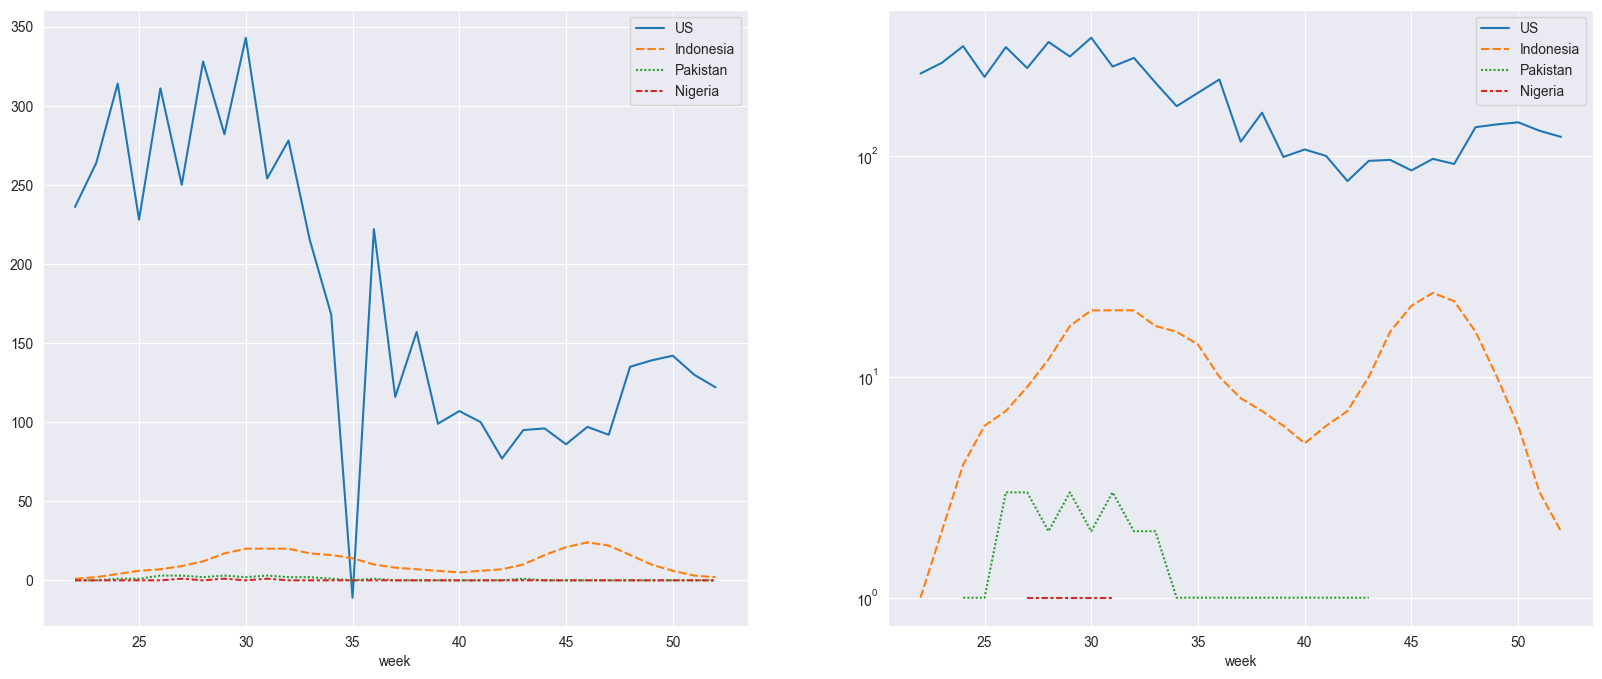

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=countries_cases_normalized_weekly_mean, ax=ax[0])
countries_cases_normalized_weekly_mean = countries_cases_normalized_weekly_mean[countries_cases_normalized_weekly_mean[countries_cases_normalized_weekly_mean.columns] > 0]
plot = sns.lineplot(data=countries_cases_normalized_weekly_mean, ax=ax[1])
plot.set(yscale='log')

In [248]:
countries_cases_normalized_weekly_median = pd.concat([us_normalized_df_median['Cases'], country_1_normalized_df_median['Cases'], country_2_normalized_df_median['Cases'], country_3_normalized_df_median['Cases']], axis=1, keys=['US']+COUNTRIES)

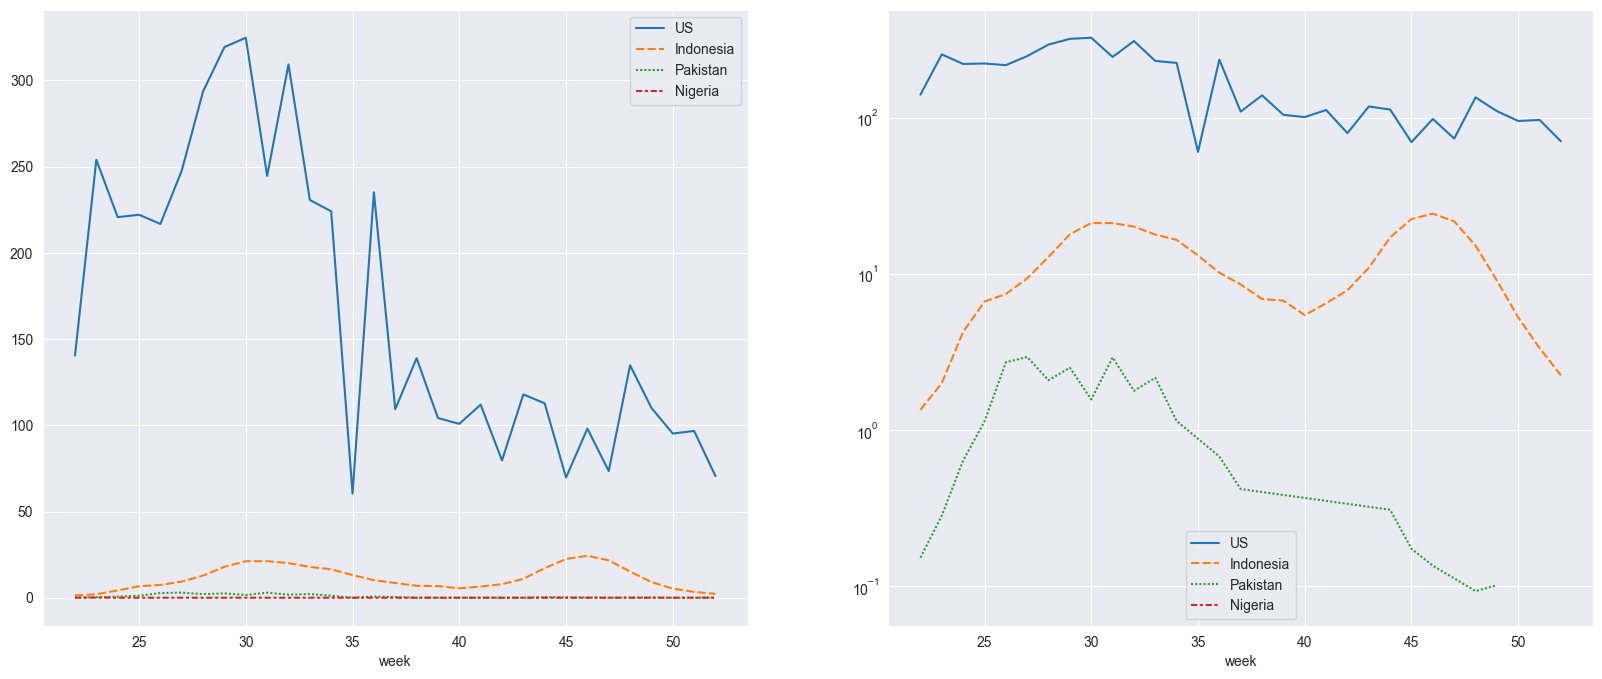

In [249]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=countries_cases_normalized_weekly_median, ax=ax[0])
countries_cases_normalized_weekly_median = countries_cases_normalized_weekly_median[countries_cases_normalized_weekly_median[countries_cases_normalized_weekly_median.columns] > 0]
plot = sns.lineplot(data=countries_cases_normalized_weekly_median, ax=ax[1])
plot = plot.set(yscale='log')

In [250]:
countries_cases_normalized_weekly_mode = pd.concat([us_normalized_df_mode['Cases'], country_1_normalized_df_mode['Cases'], country_2_normalized_df_mode['Cases'], country_3_normalized_df_mode['Cases']], axis=1, keys=['US']+COUNTRIES)

c:\Users\mosta\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cis = grouped.apply(bootstrapped_cis)


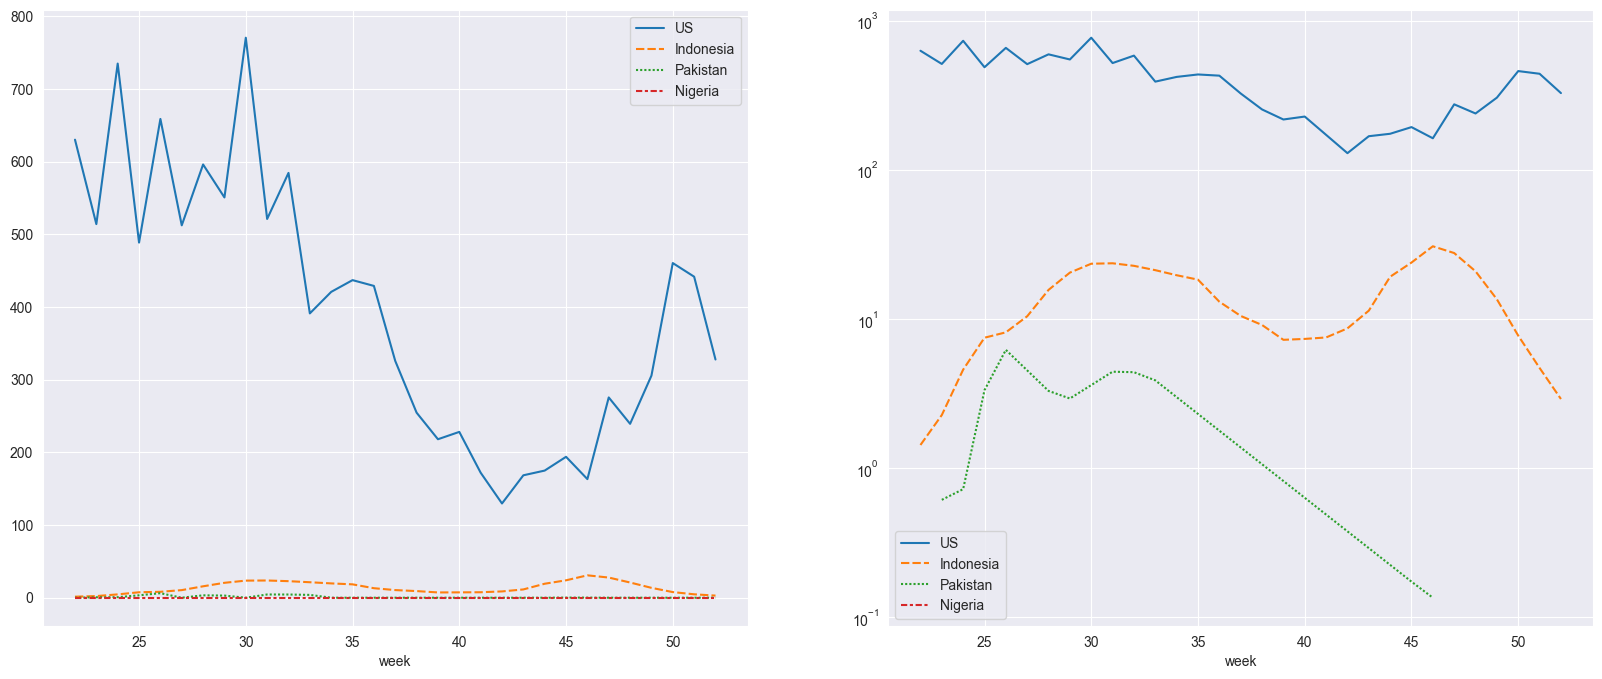

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=countries_cases_normalized_weekly_mode, ax=ax[0])
countries_cases_normalized_weekly_mode = countries_cases_normalized_weekly_mode[countries_cases_normalized_weekly_mode[countries_cases_normalized_weekly_mode.columns] > 0]
plot = sns.lineplot(data=countries_cases_normalized_weekly_mode, ax=ax[1])
plot = plot.set(yscale='log')